# Treasure Hunt Game Notebook

In [33]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [34]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [35]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

In [36]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The output below shows creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


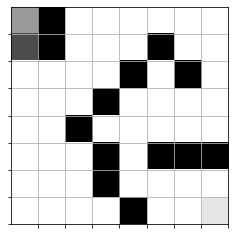

In [37]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [38]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps determine whether the pirate can win any game at all.

In [39]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

This builds the neural network model.

In [40]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# Training model

In [41]:
def qtrain(model, maze, **opt):
    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0

    for epoch in range(n_epoch):
        # Agent_cell = randomly select a free cell
        free_cells = [(i,j) for i in range(maze.shape[0]) for j in range(maze.shape[1]) if maze[i,j] == 0]
        agent_cell = random.choice(free_cells)

        # Reset the maze with agent set to above position
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()

        n_episodes = 0
        loss = 0.0
        game_over = False
        while not game_over:
            n_episodes += 1
            # Previous environment state
            previous_envstate = envstate

            # Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
            num_actions = 4  # LEFT, UP, RIGHT, DOWN
            if np.random.rand() < epsilon:
                action = np.random.randint(0, num_actions)
            else:
                qvalues = model.predict(previous_envstate)
                action = np.argmax(qvalues[0])

            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True

            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)

            # Train neural network model and evaluate loss
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(inputs, targets, epochs=8, batch_size=16, verbose=0)
            loss = model.evaluate(inputs, targets, verbose=0)

        # Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
            if win_rate > 0.9:
                epsilon = 0.05

        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)


## Testing the Model

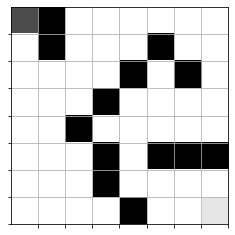

In [42]:
qmaze = TreasureMaze(maze)
show(qmaze)

In [43]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0003 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 32.7 seconds
Epoch: 001/14999 | Loss: 0.0007 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 63.1 seconds
Epoch: 002/14999 | Loss: 0.0005 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 93.4 seconds
Epoch: 003/14999 | Loss: 0.0001 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | time: 122.3 seconds
Epoch: 004/14999 | Loss: 0.0007 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 158.6 seconds
Epoch: 005/14999 | Loss: 0.0004 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 191.1 seconds
Epoch: 006/14999 | Loss: 0.0004 | Episodes: 13 | Win count: 1 | Win rate: 0.000 | time: 194.3 seconds
Epoch: 007/14999 | Loss: 0.0014 | Episodes: 144 | Win count: 1 | Win rate: 0.000 | time: 231.8 seconds
Epoch: 008/14999 | Loss: 0.0007 | Episodes: 145 | Win count: 1 | Win rate: 0.000 | time: 268.4 seconds
Epoch: 009/14999 | Loss: 0.0004 | Episodes: 11 | Win count: 2 | Win rate: 0.0

20300.847593

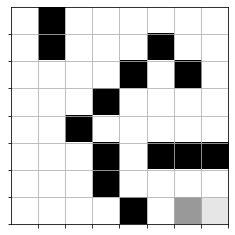

In [44]:
completion_check(model, qmaze)
show(qmaze)

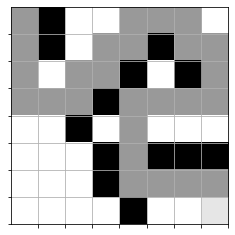

In [45]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)